In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import multiprocessing
import torchvision
import timm
import os
from transformers import *
from datasets import load_dataset
from PIL import Image
from torchinfo import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time

torch.cuda.empty_cache()
device="cuda" if torch.cuda.is_available() else "cpu"

### Data Loading and Pretrained models

In [3]:
def image_fetch(src,image_paths):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(".jpg" in l[i] or ".jpeg" in l[i] or ".png" in l[i]):
                image_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    image_fetch(str(src+l[i]+"/"),image_paths)
                except:
                    continue
                            
def class_fetch(image_paths)->(list,dict):
    s=set()
    for i in image_paths:
        s.add(i.split("/")[-2])
    d={}
    count=0
    for i in s:
        d[i]=count
        count+=1
    return list(s),d

In [4]:
class modified_dataset_loader(Dataset):
    
    def __init__(self,targ_dir=None,paths=None,transformations=None):

        if(targ_dir!=None):
            self.transform=transformations
            self.paths=[]
            image_fetch(targ_dir,self.paths)
            self.classes, self.class_to_idx=class_fetch(self.paths)
        else:
            self.transform=transformations
            self.paths=paths
            self.classes, self.class_to_idx=class_fetch(self.paths)
            


    def load_image(self,index)-> Image.Image:
        image_path=self.paths[index]
        return Image.open(image_path).convert('RGB')

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        image=self.load_image(index)
        class_val=self.class_to_idx[(self.paths[index]).split("/")[-2]]
        if(self.transform):
            image=self.transform(image)
        return image,class_val

In [5]:
batch_size=8
cpu_count=multiprocessing.cpu_count()
model_name="vit_base_patch16_384.orig_in21k_ft_in1k"

model = timm.create_model(model_name, pretrained=True)

data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

transform_data=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Resize(size=(384,384))])

data_path=[]
image_fetch("../sample_small_dataset/Train/",data_path)

train,test=train_test_split(data_path,test_size=0.5)
test,val=train_test_split(test,test_size=0.5)

train_data=modified_dataset_loader(paths=train,transformations=transform_data)
test_data=modified_dataset_loader(paths=test,transformations=transform_data)
val_data=modified_dataset_loader(paths=val,transformations=transform_data)

print(f"No. of images in Training set: {len(train)}\nNo. of images in Validation set: {len(val)}\nNo. of images in Test set: {len(test)}")

No. of images in Training set: 266
No. of images in Validation set: 134
No. of images in Test set: 133


In [6]:
train_loader=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
test_loader=torch.utils.data.DataLoader(test_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
val_loader=torch.utils.data.DataLoader(val_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)

### Freezing layers and slight modification to model

In [7]:
count=0
for param in model.parameters(): #152 layers
    if(count>=100):
        break
    param.requires_grad=False
    count+=1


### Needs to be configured for LSTM
class modified_model(torch.nn.Module):
    def __init__(self,model,out_features,modify_bool=True,add_block_dropout_bool=True):
        super(modified_model,self).__init__()
        self.model=model
        self.model_in_features=model.head.in_features
        self.model.head=nn.Linear(in_features=self.model_in_features,out_features=out_features)
        self.modify_bool=modify_bool
        self.add_block_dropout_bool=add_block_dropout_bool

        
        def add_block_dropouts():
            for i in range(len(self.model.blocks)):
                self.model.blocks[i].mlp.drop2=nn.Dropout(p=(torch.randint(low=0,high=50,size=(1,))/100).item())
        def default_block_dropouts():
            for i in range(len(self.model.blocks)):
                self.model.blocks[i].mlp.drop2=nn.Dropout(p=0)

        def modify():
            self.model.head=nn.Linear(in_features=self.model_in_features,out_features=1000)
            
            self.layer1=nn.Linear(in_features=12,out_features=128)
            self.layer2=nn.Linear(in_features=128,out_features=256)
            self.layer3=nn.Linear(in_features=256,out_features=512)
            self.relu=nn.ReLU();
            
            self.layer_final1=nn.Linear(in_features=(self.model.head.out_features+(self.layer3.out_features)),out_features=1024)
            self.layer_final2=nn.Linear(in_features=1024,out_features=out_features)
        if(self.add_block_dropout_bool):
            add_block_dropouts()
        else:
            default_block_dropouts()
        if(self.modify_bool):
            modify()

    
    def forward(self,x,y=None):
            if(self.modify_bool and y!=None):
                self.result_month=self.layer3(self.relu(self.layer2(self.relu(self.layer1(y)))))
                self.result_model=self.model(x)
                combination=torch.hstack((self.result_month,self.result_model.squeeze()))
                return self.layer_final2(self.relu(self.layer_final1(combination)))
            else:
                return self.model(x)


class simple_cnn(nn.Module):
    def __init__(self,total_classes=2):
        super().__init__()
        #[(W−K+2P)/S]+1
        
        # 384 x 384 x 3
        self.input_layer=nn.Conv2d(in_channels=3,out_channels=128,kernel_size=(3,3),stride=1,padding=1,padding_mode="replicate",bias=True)
        # 384 x 384 x 128
        self.relu1=nn.ReLU()
        self.layer1=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3))
        self.maxpool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        # 190 x 190 x 256
        
        self.relu2=nn.ReLU()
        self.layer2=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4))
        self.maxpool2=nn.MaxPool2d(kernel_size=(4,4),stride=2)
        # 91 x 91 x 512

        self.relu3=nn.ReLU()
        self.layer3=nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=(3,3))
        self.maxpool3=nn.MaxPool2d(kernel_size=(4,4),stride=2)
        # 42 x 42 x 1024

        
        self.flatten_layer=torch.flatten()
        self.classification_head=nn.Sequential(nn.Linear(in_features=42*42*1024,out_features=512),
                                              nn.ReLU(),
                                              nn.Linear(out_features=512,in_features=128),
                                              nn.ReLU(),
                                              nn.Linear(in_features=128,out_features=total_classes))
    def forward(self):
        self.convolution_output=self.flatten_layer(self.maxpool3(self.layer3(self.relu3(self.maxpool2(self.layer2(self.relu2(self.maxpool1(self.layer1(self.relu1(self.input_layer(x)))))))))
        self.net_output=self.classification_head(self.convolution_output)
        return net_output

In [8]:
model=modified_model(model,len(train_data.classes),modify_bool=False,add_block_dropout_bool=True).to(device)

In [21]:
# 384 x 384 x 3
input_layer=nn.Conv2d(in_channels=3,out_channels=128,kernel_size=(3,3),stride=1,padding=1,padding_mode="replicate",bias=True)

layer1=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3))
maxpool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
# 381 x 381 x 256

layer2=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(3,3))

# 190 x 189 x 512

print((maxpool1(layer1(input_layer(torch.rand((3,384,384)))))).shape)
#print(maxpool1())

torch.Size([256, 190, 190])


### Slight Visualizing

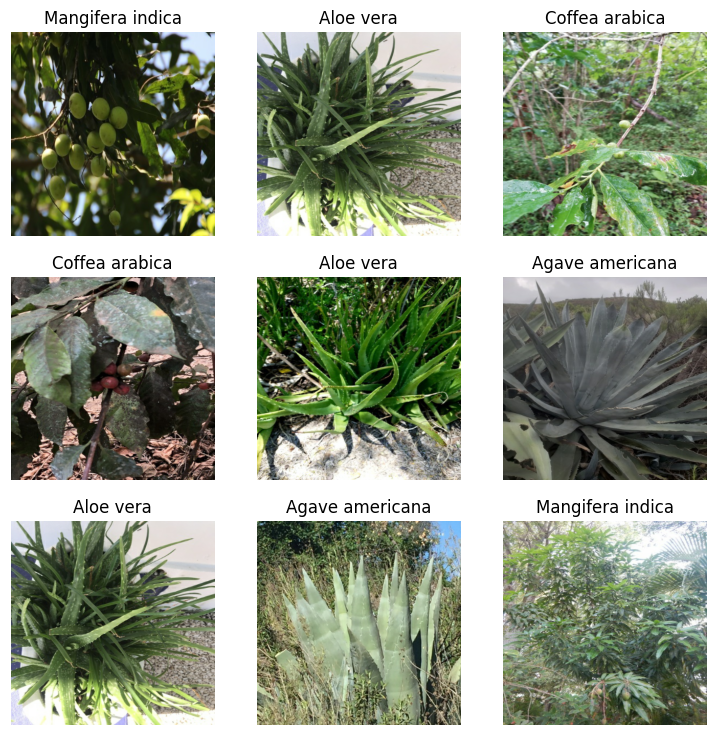

In [9]:
plt.figure(figsize=(9,9))
plt.axis(False)
for i in range(1,10):
    rand_ind=torch.randint(0,batch_size-1,size=(1,)).item()
    data=next(iter(train_loader))
    label=data[1][rand_ind]
    image=data[0][rand_ind].permute(1,2,0)
    plt.subplot(3,3,i)
    plt.title(train_data.classes[label.item()])
    plt.axis(False)
    plt.imshow(image)
    

### Misc.

In [10]:
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

#log_dir = "./"+model_name+"feature_extractor_tensorboard"
#writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)
    

### Testing the model (image)

In [11]:
model.eval()
with torch.inference_mode():
    x,y=next(iter(train_loader))
    x=x.to(device)
    y=y.to(device)
    logits=model(x)
    print(logits)
    print(loss_fn(logits.squeeze(),y))
    print(accuracy_fn(logits,y))

tensor([[-0.0281,  0.7229, -0.0783, -0.4633],
        [-0.1724, -1.0445, -0.5854,  0.4428],
        [-0.1534,  0.2077,  0.1040,  0.3550],
        [-0.3085,  0.4491, -0.5403,  0.6786],
        [ 0.0488,  0.2577, -0.5521, -0.0623],
        [-0.5896,  0.2558, -0.6732, -0.3571],
        [ 0.5797, -0.4714,  0.6652,  0.1748],
        [ 0.5392,  0.2344, -0.9745,  0.0331]], device='cuda:0')
tensor(1.4711, device='cuda:0')
0.25


### Training Loop for image classification

In [12]:
epochs=10

train_accuracy=[]
val_accuracy=[]
train_loss=[]
val_loss=[]

for i in tqdm(range(epochs)):
    print("Training:")
    model.train()
    
    #Defining accuracy and loss for train and val data
    temp_train_accuracy=[]
    temp_val_accuracy=[]
    temp_train_loss=[]
    temp_val_loss=[]

    net_train_accuracy=0
    net_val_accuracy=0
    net_train_loss=0
    net_val_loss=0
    
    with tqdm(total=len(train_loader)) as pbar:
        for x,y in train_loader:
                x=x.to(device)
                y=y.to(device)
    
                #Calculating model output
                logits=model(x)
    
                #Reseting any old gradient values
                optimizer.zero_grad()
                loss=loss_fn(logits.squeeze(),y)

            
                #Track of metrics        
                accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                temp_train_accuracy.append(accuracy_train)
                temp_train_loss.append(loss.item())
    
                #Back Propogation
                loss.backward()
            
                #Update Parameters
                optimizer.step()
            
                #Progress Bar Update
                pbar.update(1)
        pbar.close()
    #Tensorboard & Metrics for the dataset
    net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
    net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    train_accuracy.append(net_train_accuracy)
    train_loss.append(net_train_loss)
    #writer.add_scalar("Train Accuracy",net_train_accuracy,i)
    #writer.add_scalar("Train Loss",net_train_loss,i)

    #Evaluation
    print("Testing on validation data:")
    model.eval()

    with tqdm(total=len(val_loader)) as pbar2:
        for x,y in val_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(logits.squeeze().type(torch.float32),y)

                #Track of metrics
                accuracy_test=accuracy_fn(logits,y)
                temp_val_accuracy.append(accuracy_test)
                temp_val_loss.append(loss.item())

                #Progress Bar Update
                pbar2.update(1)
        pbar2.close()

    #Tensorboard & Metrics for the dataset
    net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
    net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
    val_accuracy.append(net_val_accuracy)
    val_loss.append(net_val_loss)
    #writer.add_scalar("Val Accuracy",net_val_accuracy,i)
    #writer.add_scalar("Val Loss",net_val_loss,i)

    '''
    #Saving the model
    try:
        os.makedirs(f"./{model_name}_feature_extractor/")
    except Exception as e:
        pass
    torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
    '''
    
    print(f"Epoch {i+1}:\nTrain Accuracy: {net_train_accuracy}  Train Loss: {net_train_loss}  Val Accuracy: {net_val_accuracy}  Val Loss: {net_val_loss}")
    print("\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Training:


  0%|          | 0/34 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1:
Train Accuracy: 0.8051470588235294  Train Loss: 0.5654650364372441  Val Accuracy: 0.9485294117647058  Val Loss: 0.23569704099174807


Training:


  0%|          | 0/34 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2:
Train Accuracy: 0.9338235294117647  Train Loss: 0.2168452056871234  Val Accuracy: 0.8382352941176471  Val Loss: 0.4686784807126969


Training:


  0%|          | 0/34 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3:
Train Accuracy: 0.9522058823529411  Train Loss: 0.1648270382806111  Val Accuracy: 0.9044117647058824  Val Loss: 0.2763047418694067


Training:


  0%|          | 0/34 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4:
Train Accuracy: 0.9779411764705882  Train Loss: 0.10760465893990305  Val Accuracy: 0.9411764705882353  Val Loss: 0.21048215645885862


Training:


  0%|          | 0/34 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5:
Train Accuracy: 0.9963235294117647  Train Loss: 0.03640838236606214  Val Accuracy: 0.9558823529411765  Val Loss: 0.20395430406428847


Training:


  0%|          | 0/34 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6:
Train Accuracy: 1.0  Train Loss: 0.0010432081433143193  Val Accuracy: 0.9632352941176471  Val Loss: 0.20932835278739836


Training:


  0%|          | 0/34 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7:
Train Accuracy: 1.0  Train Loss: 0.0002667426473207717  Val Accuracy: 0.9583333333333334  Val Loss: 0.24365443359505767


Training:


  0%|          | 0/34 [00:00<?, ?it/s]

KeyboardInterrupt: 